# Experiments

These are experimental models, used to investigate how a neural network behaves with the data if we use jitter/Monte Carlo sampling to simulate the measurement uncertainty. These models are not tuned, and should not be considered complete.

In [ ]:
%load_ext jupyter_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import LabelEncoder

# Core PyTorch imports
import torch
import torch.nn as nn

# Helper libraries for datasets, preprocessing and evaluation
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Create data frame, drop unnecessary columns and rows with nulls
df = pd.read_csv("cumulative.csv")

drop_cols = [
    "rowid",
    "kepid",
    "kepoi_name",
    "kepler_name",
    "koi_pdisposition",
    "koi_score",
    "koi_fpflag_nt",
    "koi_tce_plnt_num",
    "koi_tce_delivname",
    "ra",
    "dec",
    "koi_teq_err1",
    "koi_teq_err2",
]

df = df.drop(drop_cols, axis=1, errors="ignore")
df = df.dropna(how="any", axis=0)

In [3]:
# Construct an augmented dataframe where positive and negative uncertainty columns are combined into one
# All features with associated error terms
def add_err_col(new_df, df, features_with_err):
    aug_df = new_df.copy()
    for f in features_with_err:
        err = (df[f"{f}_err1"].abs() + df[f"{f}_err2"].abs()) / 2
        aug_df[f"{f}_err"] = err
    return aug_df


features_with_err = [
    "koi_period",
    "koi_time0bk",
    "koi_impact",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_insol",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
]
# Other physical features to include in the model
other_features = ["koi_teq", "koi_model_snr", "koi_kepmag"]

target = "koi_disposition"

# Create a base df with just the features and target (no errors yet)
base_df = df[features_with_err + other_features + [target]]

# augment the df with the error terms -- we expect to have 10 more columns now
aug_df = add_err_col(base_df, df, features_with_err)

In [4]:
# Create train/test split
train_df, test_df = train_test_split(
    aug_df, test_size=0.2, stratify=aug_df[target], random_state=42
)

X_train = train_df.drop(target, axis=1)
X_test = test_df.drop(target, axis=1)

y_train = train_df[target]
y_test = test_df[target]

In [5]:
# Sample each feature with error from a normal distribution with the appropriate standard deviation
def noisy_sample(df, features_with_err):
    df_noisy = df.copy()
    for f in features_with_err:
        sigma = df[f"{f}_err"]
        noise = np.random.normal(0, sigma)
        df_noisy[f] = df[f] + noise
    return df_noisy


# For NN with jitter, we don't pass in the err terms
X_train_no_err = train_df[features_with_err + other_features]
X_test_no_err = test_df[features_with_err + other_features]

In [9]:
# Use LabelEncoder to encode numerical values
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [14]:
# Create function for evaluating models
def evaluate_model(y_true, preds, target_names=le.inverse_transform([0, 1, 2])):
    print("Classification Report:\n")
    print(classification_report(y_true, preds, target_names=target_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, preds)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()
    plt.xticks(
        np.arange(len(le.inverse_transform([0, 1, 2]))),
        le.inverse_transform([0, 1, 2]),
        rotation=45,
    )
    plt.yticks(
        np.arange(len(le.inverse_transform([0, 1, 2]))), le.inverse_transform([0, 1, 2])
    )
    plt.tight_layout()
    plt.show()


def plot_loss_and_accuracy(train_accs, train_loss):
    # Plot training loss and accuracy
    window = 100  # moving average window
    smoothed_acc = pd.Series(train_accs).rolling(window).mean()
    smoothed_loss = pd.Series(train_loss).rolling(window).mean()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(smoothed_loss, label=f"Train Loss (avg {window})")
    plt.title("Training Loss (Smoothed)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(smoothed_acc, label=f"Train Accuracy (avg {window})")
    plt.title("Training Accuracy (Smoothed)")
    plt.legend()
    plt.show()

## Model 1: Neural Network with Errors Included as Features, No Sampling

In [11]:
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create classifier
class ClassifierNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        return self.net(x)

In [12]:
# Train model on data
# TODO: set random state for repeatable results
model = ClassifierNet(X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Step 1: Reset gradients
        optimizer.zero_grad()

        # Step 2: Complete forward pass
        output = model(xb)

        # Step 3: Compute loss
        loss = criterion(output, yb)

        # Step 4: Back Propagation
        loss.backward()

        # Step 5: Update weights
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(output, dim=1)
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

        train_loss = total_loss / total
        train_acc = total_correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}"
        )

Epoch 10/300: train_loss=0.9988, train_acc=0.6627
Epoch 20/300: train_loss=0.7272, train_acc=0.6850
Epoch 30/300: train_loss=0.7402, train_acc=0.6903
Epoch 40/300: train_loss=0.6928, train_acc=0.6985
Epoch 50/300: train_loss=0.7208, train_acc=0.7131
Epoch 60/300: train_loss=0.6559, train_acc=0.7199
Epoch 70/300: train_loss=0.6369, train_acc=0.7307
Epoch 80/300: train_loss=0.6418, train_acc=0.7260
Epoch 90/300: train_loss=0.6283, train_acc=0.7334
Epoch 100/300: train_loss=0.6154, train_acc=0.7391
Epoch 110/300: train_loss=0.6197, train_acc=0.7354
Epoch 120/300: train_loss=0.6046, train_acc=0.7425
Epoch 130/300: train_loss=0.6008, train_acc=0.7442
Epoch 140/300: train_loss=0.6029, train_acc=0.7513
Epoch 150/300: train_loss=0.5884, train_acc=0.7546
Epoch 160/300: train_loss=0.5913, train_acc=0.7450
Epoch 170/300: train_loss=0.6706, train_acc=0.7587
Epoch 180/300: train_loss=0.5780, train_acc=0.7568
Epoch 190/300: train_loss=0.5756, train_acc=0.7621
Epoch 200/300: train_loss=0.5763, train_

Classification Report:

                precision    recall  f1-score   support

     CANDIDATE       0.58      0.40      0.48       433
     CONFIRMED       0.63      0.93      0.75       456
FALSE POSITIVE       0.87      0.79      0.83       910

      accuracy                           0.73      1799
     macro avg       0.69      0.71      0.69      1799
  weighted avg       0.74      0.73      0.72      1799



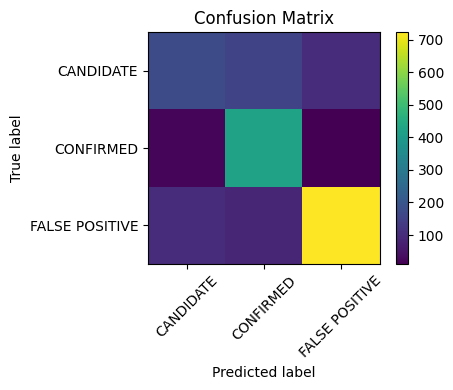

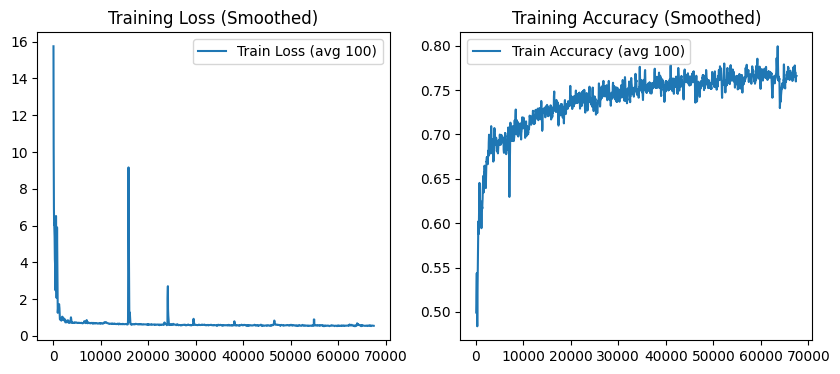

In [15]:
# Evaluate model
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    preds = torch.argmax(logits, dim=1).cpu().numpy().flatten()
    y_true = y_test_t.cpu().numpy()

evaluate_model(y_true, preds)
plot_loss_and_accuracy(train_accs, train_losses)

# Model 2: Neural Network with Jitter

In [16]:
# TODO: set random state for repeatable results
model = ClassifierNet(X_train_no_err.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 500
train_losses, train_accs = [], []

for epoch in range(num_epochs):

    noisy_train_data = noisy_sample(train_df, features_with_err)

    X_train_noisy = noisy_train_data[features_with_err + other_features]

    X_train_noisy_t = torch.tensor(X_train_noisy.values, dtype=torch.float32)

    train_loader = DataLoader(
        TensorDataset(X_train_noisy_t, y_train_t), batch_size=32, shuffle=True
    )
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Step 1: Reset gradients
        optimizer.zero_grad()

        # Step 2: Complete forward pass
        output = model(xb)

        # Step 3: Compute loss
        loss = criterion(output, yb)

        # Step 4: Back Propagation
        loss.backward()

        # Step 5: Update weights
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(output, dim=1)
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

        train_loss = total_loss / total
        train_acc = total_correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}"
        )

Epoch 10/500: train_loss=2.2612, train_acc=0.5749
Epoch 20/500: train_loss=2.9959, train_acc=0.6121
Epoch 30/500: train_loss=1.2967, train_acc=0.6109
Epoch 40/500: train_loss=0.8402, train_acc=0.6328
Epoch 50/500: train_loss=0.9326, train_acc=0.6549
Epoch 60/500: train_loss=0.7616, train_acc=0.6668
Epoch 70/500: train_loss=0.7421, train_acc=0.6737
Epoch 80/500: train_loss=0.7314, train_acc=0.6830
Epoch 90/500: train_loss=0.7263, train_acc=0.6873
Epoch 100/500: train_loss=0.7157, train_acc=0.6964
Epoch 110/500: train_loss=0.7064, train_acc=0.6979
Epoch 120/500: train_loss=0.6958, train_acc=0.6983
Epoch 130/500: train_loss=0.6921, train_acc=0.7074
Epoch 140/500: train_loss=0.6898, train_acc=0.7128
Epoch 150/500: train_loss=0.6841, train_acc=0.7103
Epoch 160/500: train_loss=0.6803, train_acc=0.7146
Epoch 170/500: train_loss=0.6727, train_acc=0.7175
Epoch 180/500: train_loss=0.6696, train_acc=0.7211
Epoch 190/500: train_loss=0.6859, train_acc=0.7183
Epoch 200/500: train_loss=0.6634, train_

torch.Size([1799, 3])
Classification Report:

                precision    recall  f1-score   support

     CANDIDATE       0.66      0.42      0.51       433
     CONFIRMED       0.69      0.81      0.75       456
FALSE POSITIVE       0.81      0.87      0.84       910

      accuracy                           0.75      1799
     macro avg       0.72      0.70      0.70      1799
  weighted avg       0.74      0.75      0.74      1799



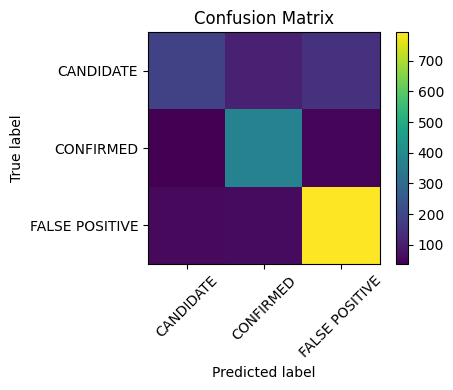

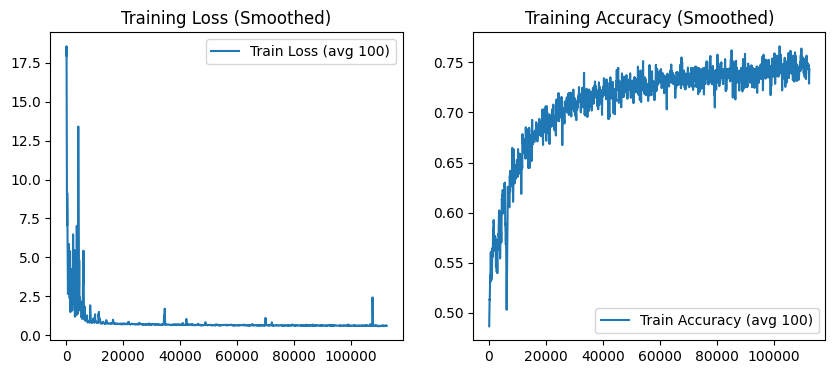

In [17]:
X_test_no_err_t = torch.tensor(X_test_no_err.values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    logits = model(X_test_no_err_t)
    print(logits.shape)
    preds = torch.argmax(logits, dim=1).cpu().numpy().flatten()
    y_true = y_test_t.cpu().numpy()

evaluate_model(y_true, preds)
plot_loss_and_accuracy(train_accs, train_losses)